# 80_ra271.352_dec-29.642_MAXIJ1803

In [1]:
from pathlib import Path
import numpy as np
import arviz as az
import graphviz as gv
import utility_functions as ufn
import importlib
import seaborn as sns

importlib.reload(ufn)
az.style.use("arviz-white")

RANDOM_SEED = 2023-11-21
rng = np.random.default_rng(RANDOM_SEED)

OVERWRITE_TRACES = True

Running on PyMC v5.6.1
Running on PyMC v5.6.1


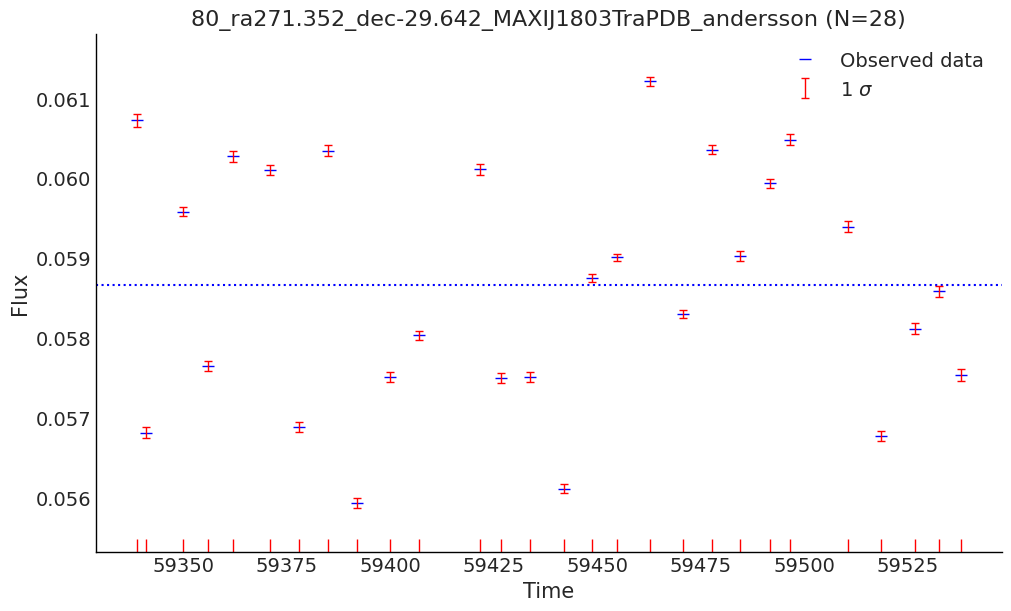

In [2]:
# File paths to CSVs of flux density observations.
csv_paths_list = sorted(list(Path('data_raw').iterdir()))
csv_path = csv_paths_list[3]
ufn.plot_lc(csv_path)

## SE GP + Periodic GP

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{P}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}, \quad k_\textrm{P}(\tau) = \eta_\textrm{P} \exp \left\{ -\frac{1}{2\ell^2_\textrm{P}}\sin^2 \left(\pi\frac{\tau}{T}\right)\right\}$$

$$\ell_\textrm{SE} \sim \textrm{InvGamma}(\alpha = 3, \beta = 8 \times \textrm{min. t gap})$$

$$\ell_\textrm{P} \sim \textrm{InvGamma}(\alpha = 3, \beta = 8 \times \textrm{min. t gap})$$

$$\eta_\textrm{SE} \sim \mathcal{N}^+(0, 1)$$

$$\eta_\textrm{P} \sim \mathcal{N}^+(0, 1)$$

$$T \sim \mathcal{U}[\textrm{t max gap}, \textrm{t range}]$$

$$\sigma_{\textrm{WN},i} \sim \mathcal{N}^+(\textrm{std err}(y_i), \textrm{SD}(\textrm{std err}(\boldsymbol{y})))$$

Sampling: [T, ell_Per, ell_SE, eta_Per, eta_SE, sig, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_SE, eta_Per, ell_SE, ell_Per, T, sig]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 392 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [f_star, f_star_Per, f_star_SE, y_star]


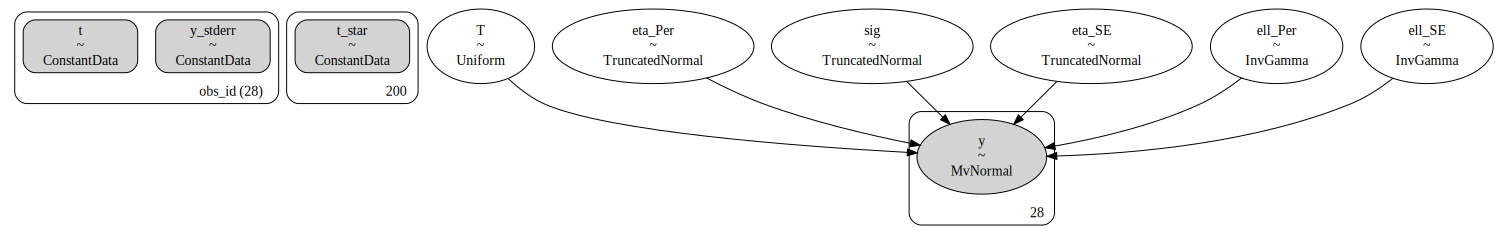

In [3]:
gpSE_gpPer_trace_path = Path(f"traces/{csv_path.stem}_gpSE_gpPer_idata.nc")
gpSE_gpPer_dag_path = Path(f'dags/{csv_path.stem}_gpSE_gpPer_dag.dot')

if gpSE_gpPer_trace_path.is_file() and not OVERWRITE_TRACES:
    gpSE_gpPer_trace = az.from_netcdf(gpSE_gpPer_trace_path)
    gpSE_gpPer_dag = gv.Source.from_file(gpSE_gpPer_dag_path)
else:
    gpSE_gpPer_trace, gpSE_gpPer_dag = ufn.fit_gpSE_gpPer(csv_path, rng_seed=rng);
    az.to_netcdf(gpSE_gpPer_trace, gpSE_gpPer_trace_path)
    with open(gpSE_gpPer_dag_path, 'w') as writehandle:
        writehandle.write(gpSE_gpPer_dag.source)

gv.Source(gpSE_gpPer_dag.source)

In [4]:
variable_names = ["ell_SE", "ell_Per", "eta_SE", "eta_Per", "T", "sig"]
ufn.print_post_summary(gpSE_gpPer_trace, variable_names)

,median,mad,eti_16%,eti_84%,mcse_median,ess_median,ess_tail,r_hat,mean,sd
ell_SE,9.141520,3.946008e+00,4.492327e+00,17.339529,5.291043e-01,185.128062,320.570395,1.015026,15.202219,46.015691
ell_Per,22.657980,9.050112e+00,1.187912e+01,43.638712,1.303617e+00,194.110537,285.414670,1.030587,31.741663,40.483576
eta_SE,0.000001,5.451662e-07,4.954536e-07,0.000002,7.640183e-08,177.774381,238.146176,1.027985,0.000799,0.015006
eta_Per,0.009005,7.036215e-03,2.494346e-03,0.090262,2.787754e-03,38.723752,147.846240,1.065305,0.070809,0.188614
T,16.298546,3.815604e+00,1.262437e+01,43.418980,1.202332e+00,33.391712,694.490397,1.067726,24.943370,13.399907
sig,0.000062,5.071875e-06,5.453001e-05,0.000070,7.360275e-07,190.169323,386.474188,1.038845,0.000062,0.000008


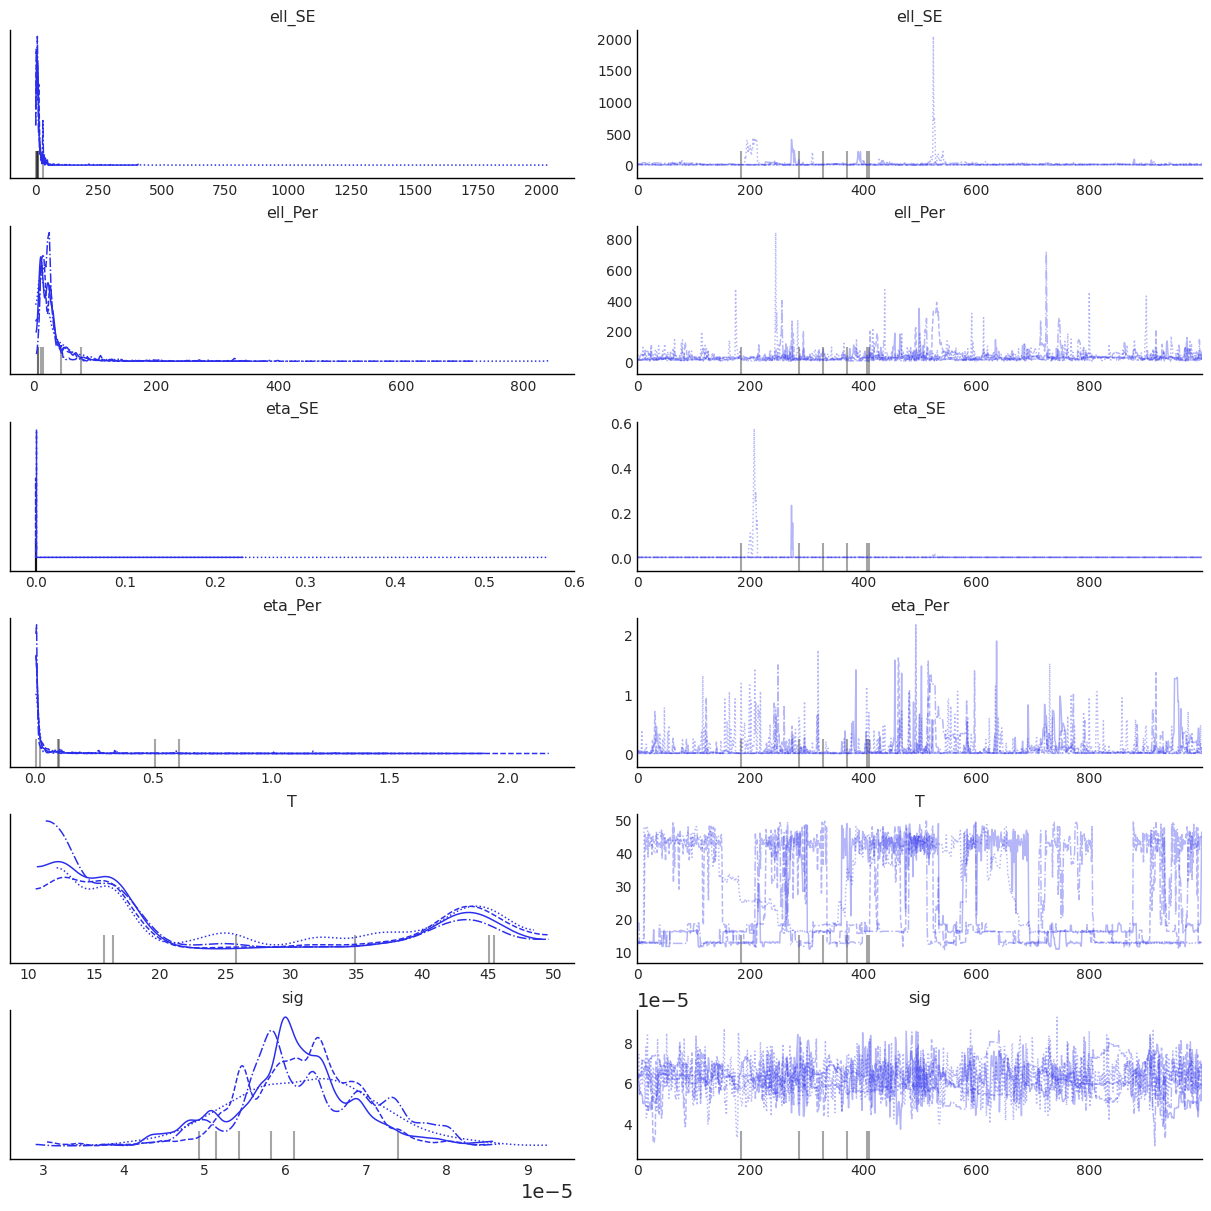

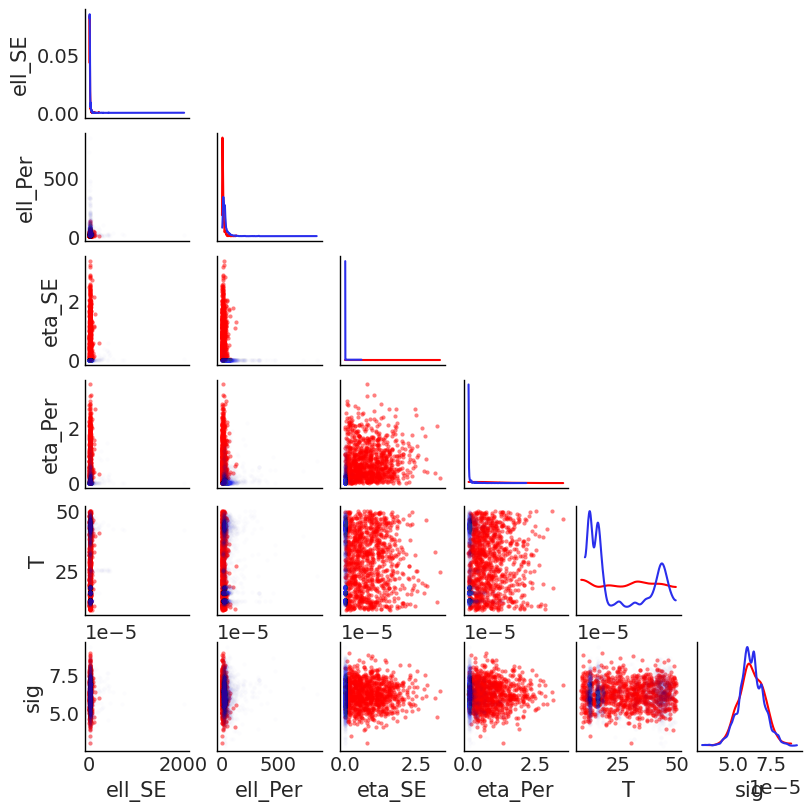

In [5]:
ufn.plot_traces(gpSE_gpPer_trace, variable_names)
ufn.plot_priorpost_cnr(gpSE_gpPer_trace, variable_names)

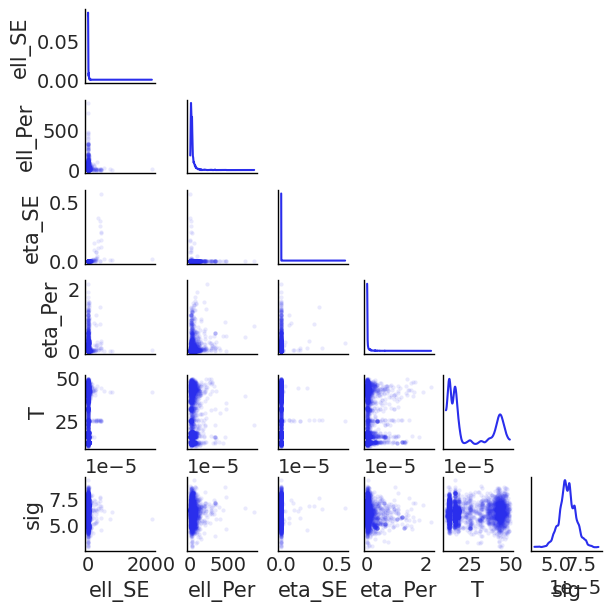

In [6]:
ufn.plot_post_cnr(gpSE_gpPer_trace, variable_names=variable_names)

array([15.41169715, 12.47796866, 42.79316311, 17.36751615])

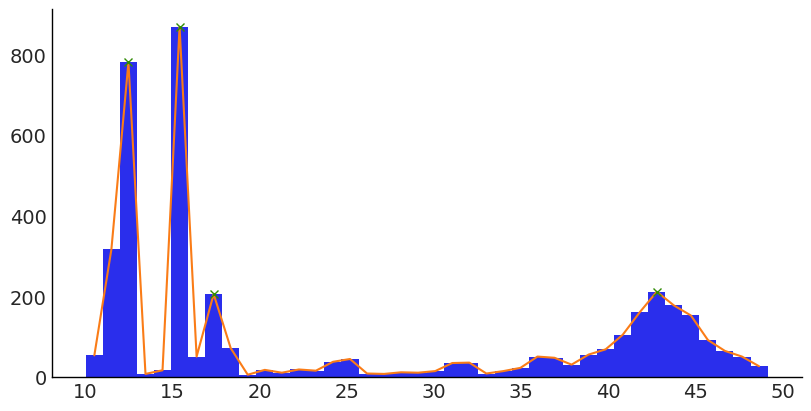

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
n, bins, patches = ax.hist(az.extract(gpSE_gpPer_trace, group="posterior", var_names="T"), align="left", bins=40);

peaks, _ = find_peaks(n, height=100)
ax.plot(bins[0:-1],n)
ax.plot(bins[peaks], n[peaks], "x")
T_modes = bins[peaks][np.argsort(-n[peaks])] # peak locations, descending order by height
T_modes

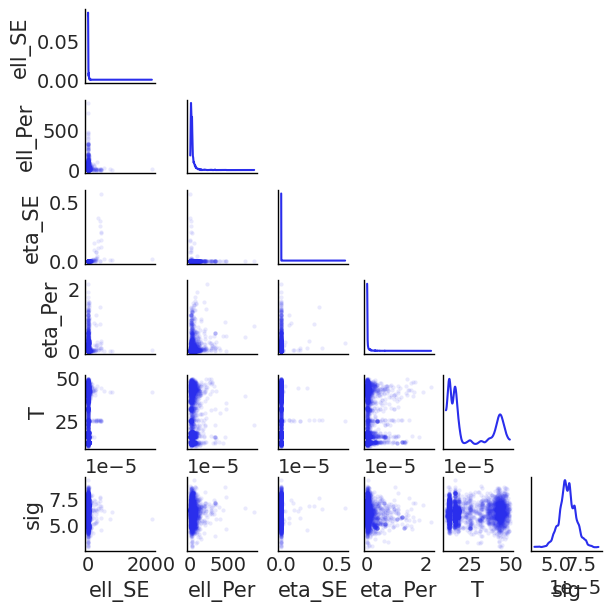

In [20]:
ufn.plot_post_cnr(gpSE_gpPer_trace,  variable_names=["ell_SE", "ell_Per", "eta_SE", "eta_Per", "T", "sig"])

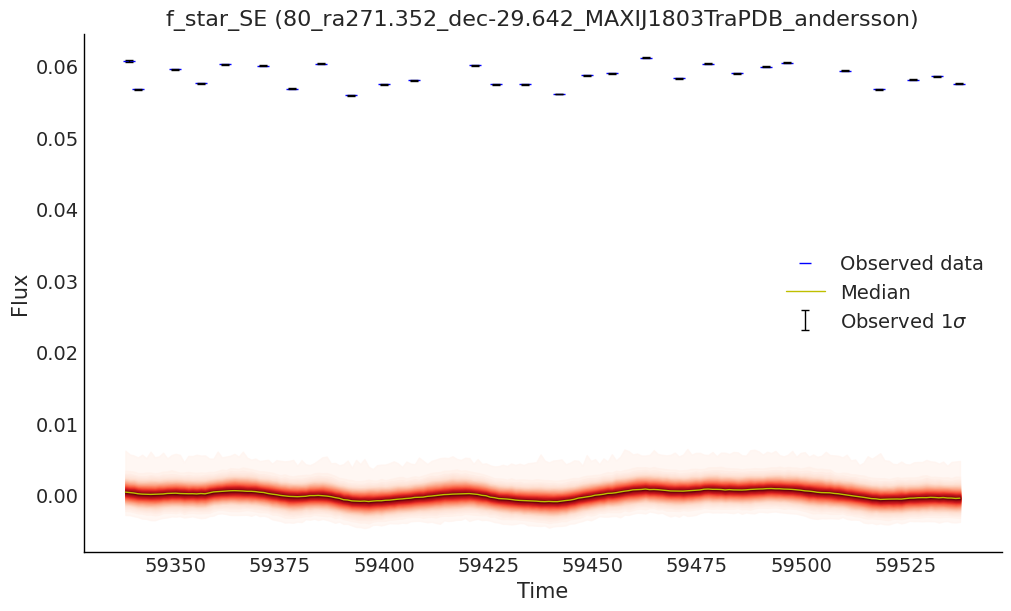

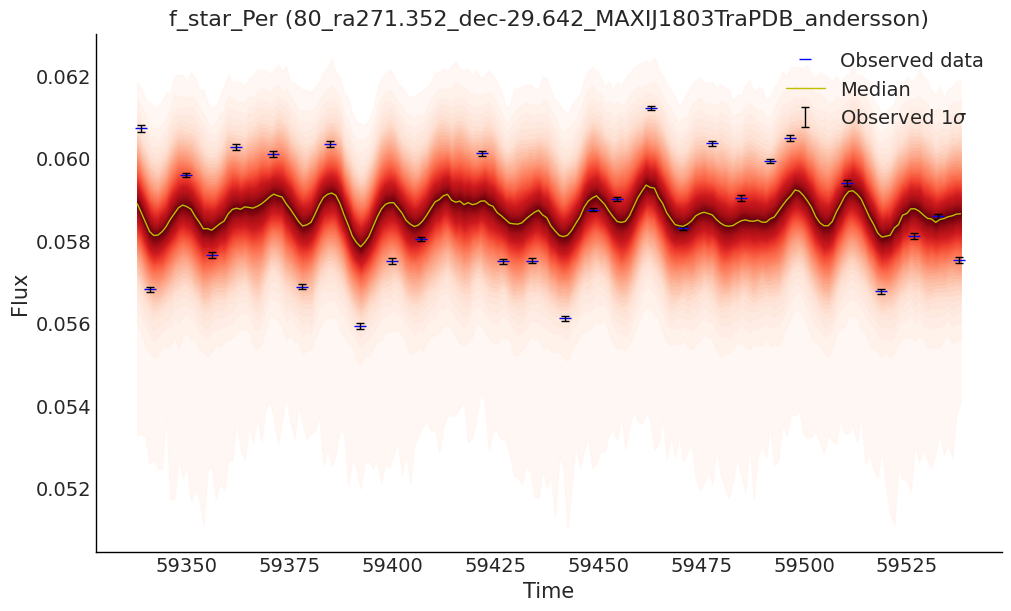

In [9]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_SE")
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_Per")

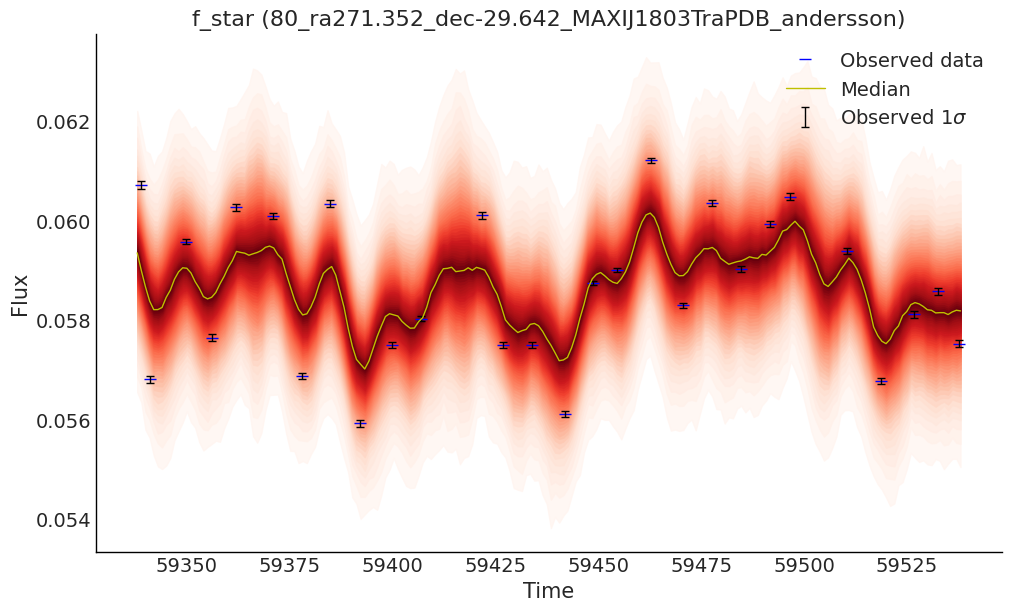

In [10]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star")

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '


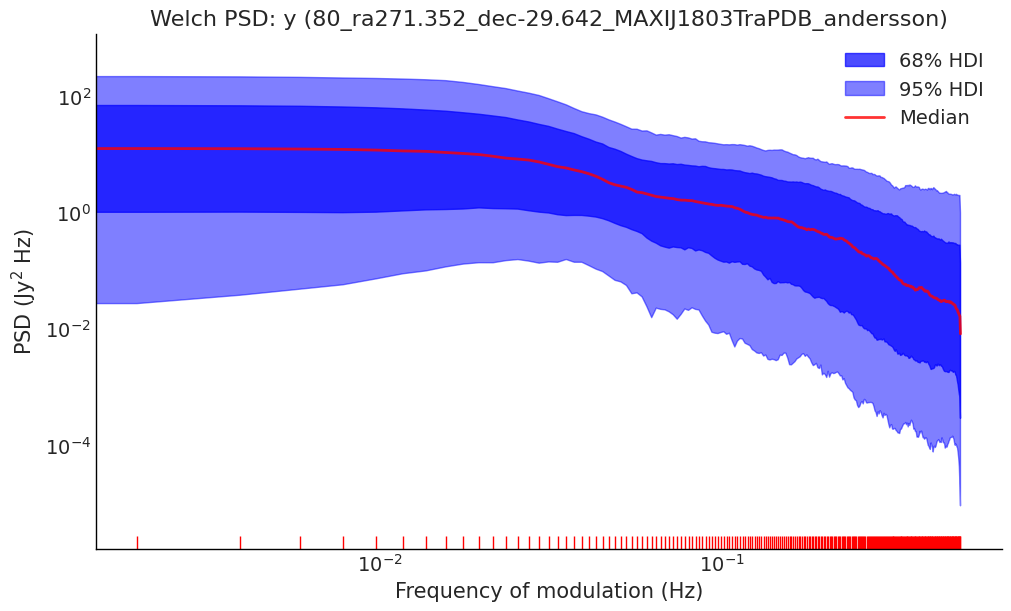

In [11]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="prior_predictive", variable_name="y")
this_xlim = plt.xlim()

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


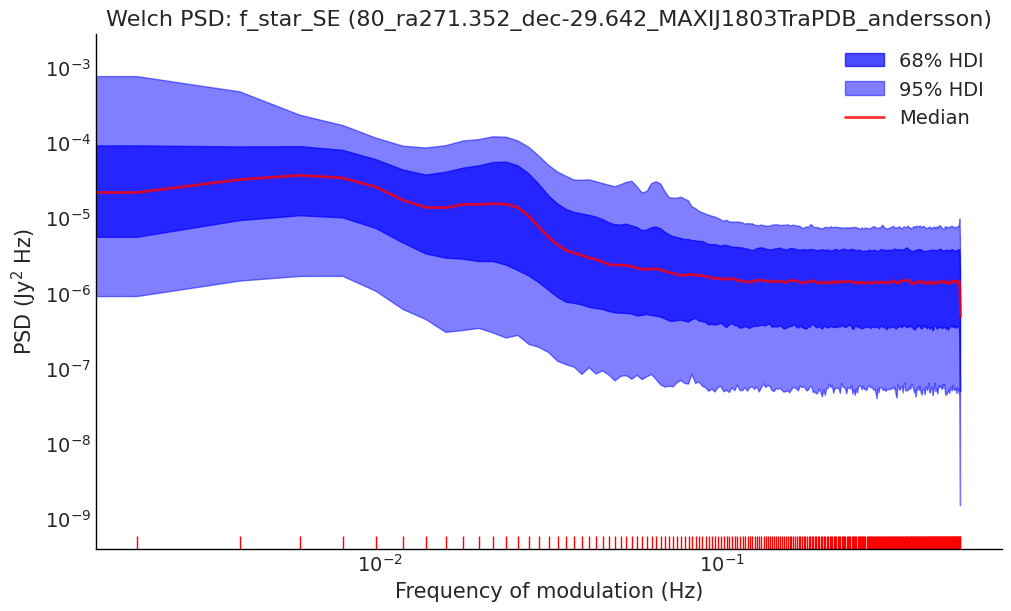

In [12]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_SE");

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


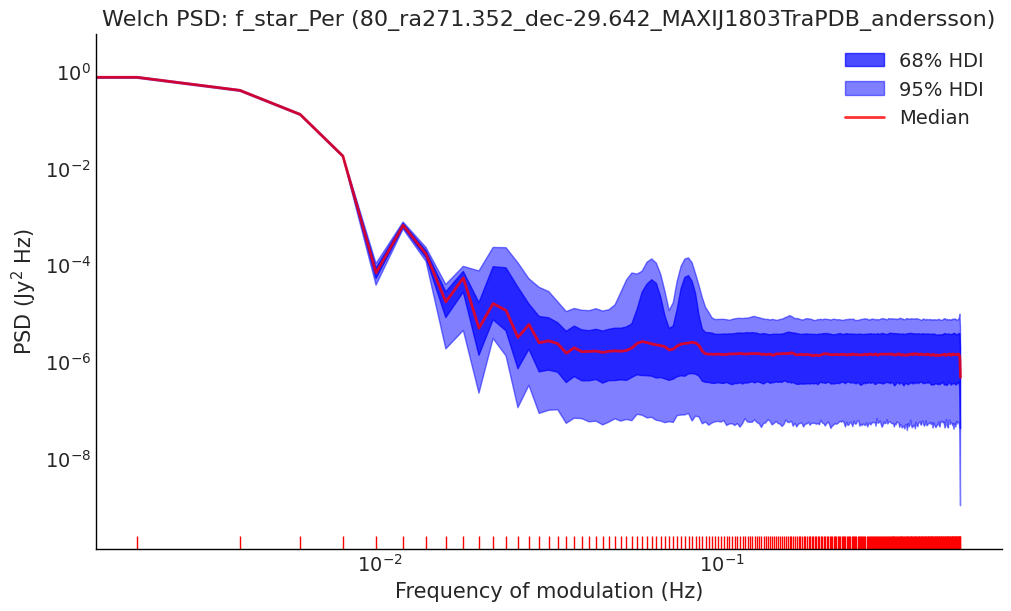

In [13]:
ufn.plot_welch_psd(gpSE_gpPer_trace, variable_name="f_star_Per");

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


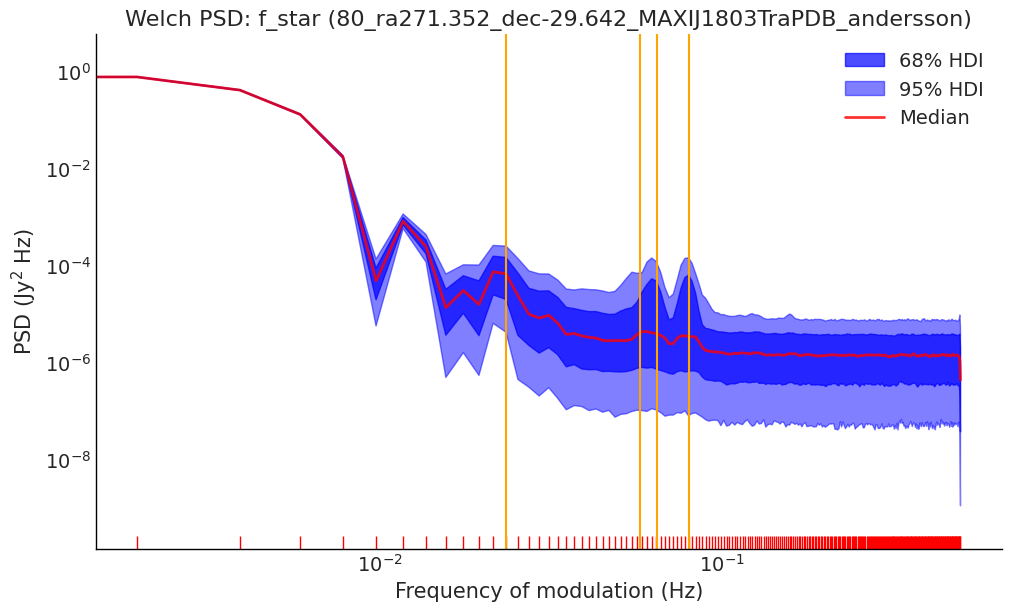

In [14]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")
for l in T_modes: 
    plt.axvline(x=1/l, c="orange")

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


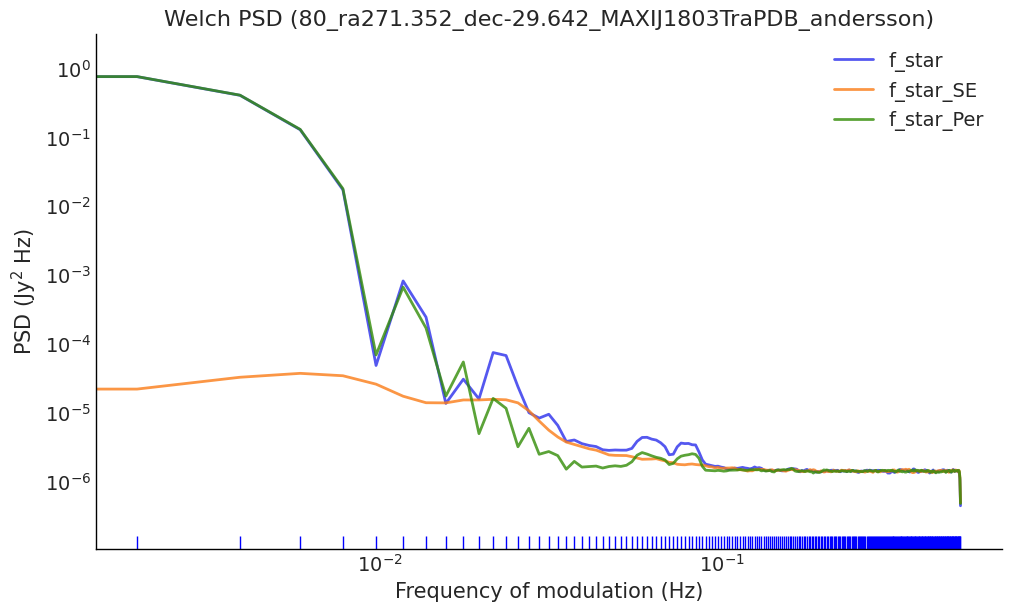

In [15]:
ufn.plot_welch_psds(gpSE_gpPer_trace, variable_names=["f_star", "f_star_SE", "f_star_Per"])

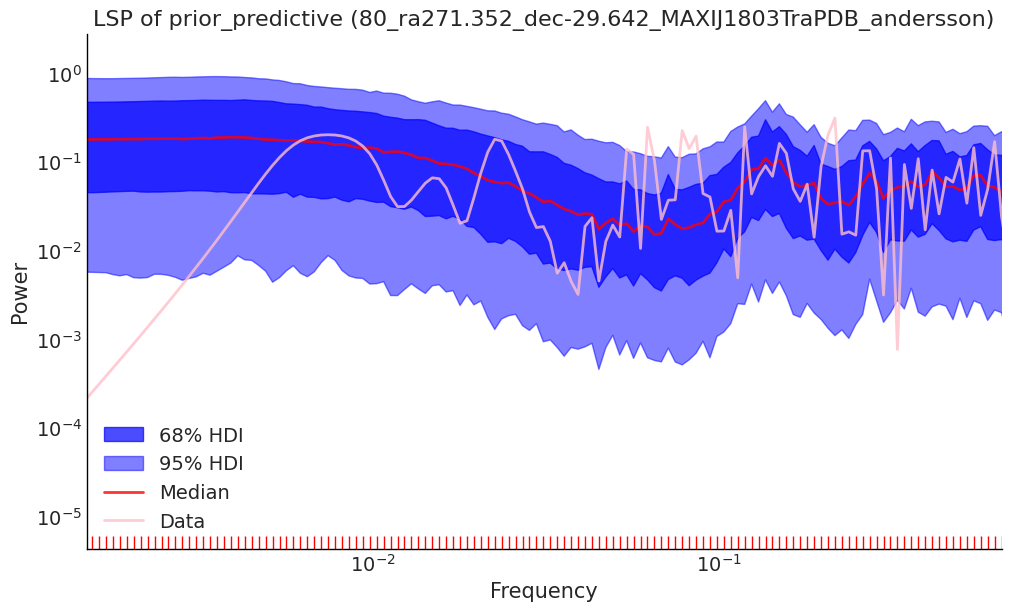

In [16]:
ufn.plot_lsp(gpSE_gpPer_trace, "prior_predictive", "y")
plt.xlim(this_xlim);

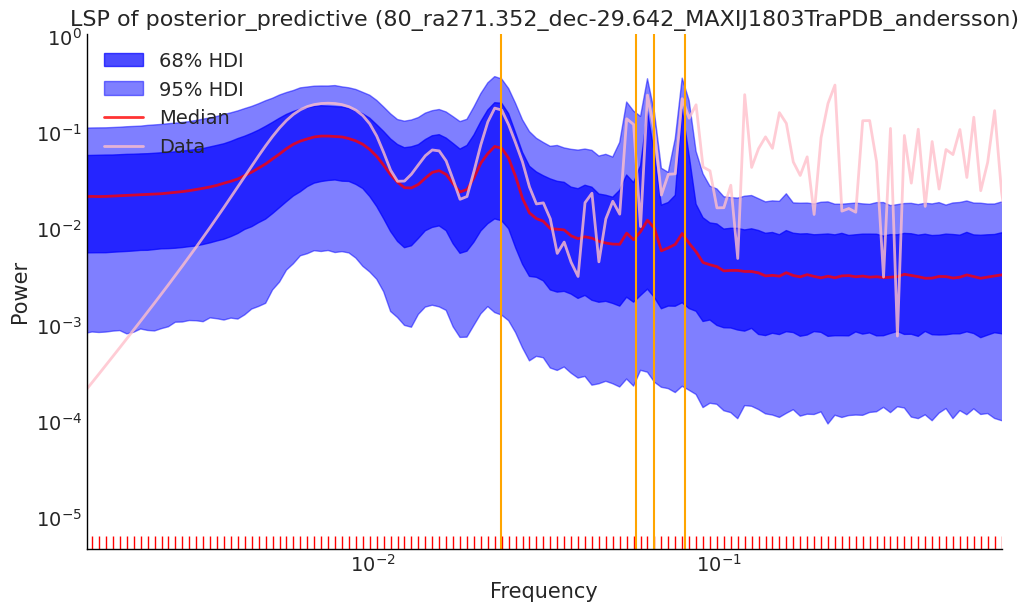

In [19]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")
plt.xlim(this_xlim);
for l in T_modes: 
    plt.axvline(x=1/l, c="orange")

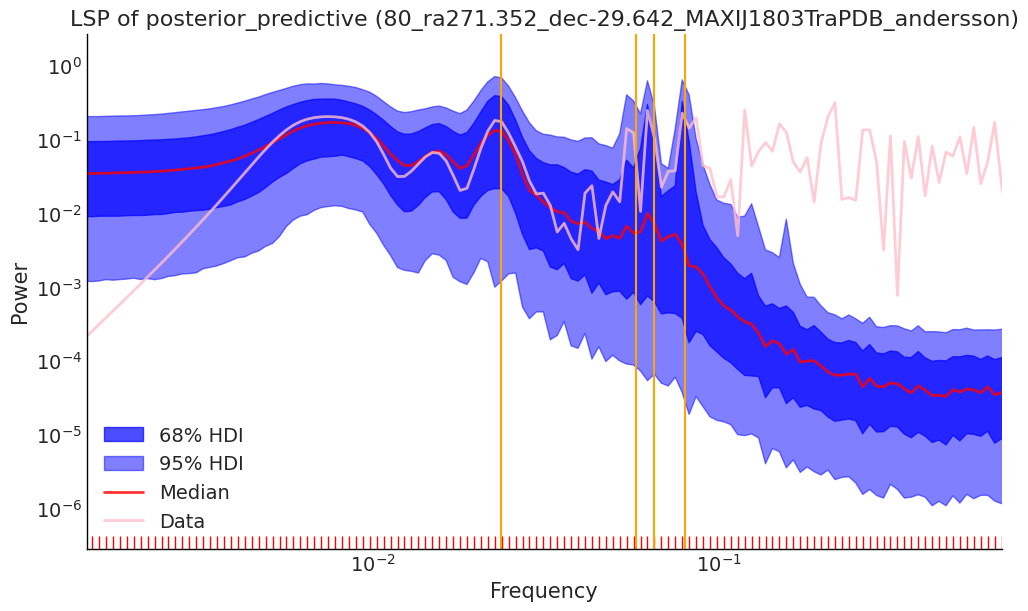

In [18]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="y_star")
plt.xlim(this_xlim);
for l in T_modes: 
    plt.axvline(x=1/l, c="orange")